In [1]:
%load_ext autoreload
%autoreload 2
from dpe import DPE
from lib_data import *
import matplotlib.pyplot as plt
import numpy as np
from lib_nn_dpe import NN_dpe
from IPython import display

load_workspace(vars(), 'dataset/20190815-132601-weights')
load_workspace(vars(), 'dataset/mnist')

Loaded: weights, 
Loaded: train_images, train_labels, test_images, test_labels, 


In [3]:
dpe = DPE('COM3')

Connecting to serial
DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
[INFO] Elapsed time = 0.04s
Serial disconnected


In [15]:
dpe.set_clock(5)

Connecting to serial
Setting ADC_CK freq=5000.0kHz
Setting CK_ARRAY freq=5000.0kHz
[INFO] Elapsed time = 0.00s
Serial disconnected


In [16]:
g = dpe.read(0)

Connecting to serial
[INFO] Elapsed time = 0.87s
Serial disconnected


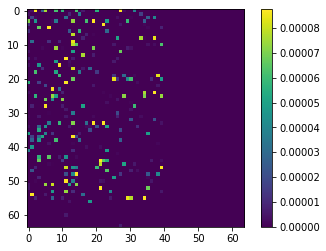

In [17]:
plt.imshow(g)
plt.colorbar()

In [6]:
nn = NN_dpe(weights)

In [41]:
img_idx = 6

image = test_images[img_idx]
vectors = nn._conv_flattern(image)
vectors.max()

1.0

In [42]:
outputs = dpe.multiply(1, vectors, c_sel=[0, 14]) / nn.Gratio

Connecting to serial
[INFO] Elapsed time = 1.48s
Serial disconnected


In [43]:
outputs.shape

(400, 14)

In [44]:
linear_factors_conv = [
       [ 1.40307296e+01, -2.58173509e-05],
       [ 1.41033398e+01,  5.21875110e-05],
       [ 1.55031527e+01,  1.58425174e-05],
       [ 1.54161942e+01, -9.61619642e-05],
       [ 1.32260040e+01,  1.93861940e-05],
       [ 1.40131446e+01,  1.06075518e-04],
       [ 1.17492652e+01, -2.25368275e-05],
       [ 1.45670486e+01, -4.82399742e-05],
       [ 1.36731289e+01,  1.02902647e-04],
       [ 1.45841854e+01, -3.02688972e-05],
       [ 1.57162630e+01,  4.17033681e-05],
       [ 1.60243388e+01,  4.15976155e-05],
       [ 1.64551436e+01,  2.55184336e-05],
       [ 1.61364337e+01, -7.45189375e-05]]

for c in range(outputs.shape[1]):
    outputs[:,c] = outputs[:,c] * linear_factors_conv[c][0] + linear_factors_conv[c][1]

In [45]:
result = outputs[:, ::2] - outputs[:,1::2]
x = result.reshape(20,20,-1)
# for i in range(7):
#     plt.figure(i)
#     plt.imshow(x[:,:,i])
#     plt.colorbar()

In [46]:
x1 = nn.relu(x)
x1 = nn.max_pooling(x1)
x1 = nn.flattern(x1)
y = nn.dense(x1)

print('predicted', y.argmax())
print('label', test_labels[img_idx])

predicted 4
label 4


In [56]:
xs = []
acc = []

for img_idx in range(len(test_images)):
    
    
    image = test_images[img_idx]
    vectors = nn._conv_flattern(image)
    
    outputs = dpe.multiply(1, vectors, c_sel=[0, 14]) / nn.Gratio
    
    for c in range(outputs.shape[1]):
        outputs[:,c] = outputs[:,c] * linear_factors_conv[c][0] + linear_factors_conv[c][1]
    
    result = outputs[:, ::2] - outputs[:,1::2]
    x = result.reshape(20,20,-1)
    
    x1 = nn.relu(x)
    x1 = nn.max_pooling(x1)
    x1 = nn.flattern(x1)
    
    xs.append(x1)
    y = nn.dense(x1)
    
    display.clear_output(wait=True)

    print(f'idx={img_idx}, predicted: {y.argmax()}, label: {test_labels[img_idx]}')
    acc.append( y.argmax() == test_labels[img_idx] )
    print(f'\t Accuracy = {np.mean(acc)*100:.2f}%')
save_workspace(vars(), note='mnist_xs')

idx=9999, predicted: 2, label: 6
	 Accuracy = 81.73%
Saving In(<class 'list'>), Out(<class 'dict'>), weights(<class 'numpy.ndarray'>), train_images(<class 'numpy.ndarray'>), train_labels(<class 'numpy.ndarray'>), test_images(<class 'numpy.ndarray'>), test_labels(<class 'numpy.ndarray'>), g(<class 'numpy.ndarray'>), img_idx(<class 'int'>), image(<class 'numpy.ndarray'>), vectors(<class 'numpy.ndarray'>), outputs(<class 'numpy.ndarray'>), linear_factors_conv(<class 'list'>), c(<class 'int'>), x(<class 'numpy.ndarray'>), i(<class 'int'>), result(<class 'numpy.ndarray'>), x1(<class 'numpy.ndarray'>), y(<class 'numpy.ndarray'>), xs(<class 'list'>), acc(<class 'list'>), to 20190820-055900-mnist_xs.pkl
Saving In(<class 'list'>), weights(<class 'numpy.ndarray'>), train_images(<class 'numpy.ndarray'>), train_labels(<class 'numpy.ndarray'>), test_images(<class 'numpy.ndarray'>), test_labels(<class 'numpy.ndarray'>), g(<class 'numpy.ndarray'>), img_idx(<class 'int'>), image(<class 'numpy.ndarray'

In [12]:
load_workspace(vars(), '20190820-055900-mnist_xs')
xs = np.array(xs)

In [6]:
xs.shape

(10000, 112)

In [7]:
xs = np.concatenate((xs, np.ones((xs.shape[0], 1))), axis=1)

In [8]:
xs.shape

(10000, 113)

Connecting to serial
[INFO] Elapsed time = 0.25s
Serial disconnected


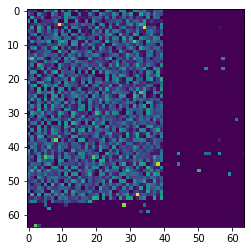

In [9]:
plt.imshow(dpe.read(2))

In [38]:
x = xs[0:400]

x1 = x[:,:57].T
x2 = x[:,57:].T

sc1 = x1.max()
sc2 = x2.max()

Gfc1 = nn.Gfc[:57]
Gfc2 = nn.Gfc[57:]

x1 = x1 / sc1
x2 = x2 / sc2

In [62]:
def lin_corr(outputs, factors):
    result = np.zeros(outputs.shape)
    for c in range(outputs.shape[1]):
        result[:,c] = outputs[:,c] * factors[c][0] + factors[c][1]
        
    return result

Connecting to serial
[INFO] Elapsed time = 1.87s
Serial disconnected


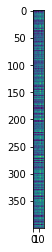

In [76]:
outputs  = dpe.multiply(2, x1, c_sel=[0, 20])
plt.imshow(outputs)
outputs = lin_corr(outputs, lin_cor_fc1)

In [14]:
lin_cor_fc1 = [
       [ 1.65705364e+01, -4.76661730e-06],
       [ 1.52014391e+01, -7.32910667e-06],
       [ 1.83622860e+01, -1.03660227e-04],
       [ 1.46453131e+01,  8.72582481e-05],
       [ 1.57026572e+01,  5.49433331e-06],
       [ 1.75302910e+01, -5.91984363e-05],
       [ 1.70097444e+01, -3.77425017e-06],
       [ 1.66811834e+01, -5.92705383e-05],
       [ 1.58138030e+01, -8.54206565e-05],
       [ 1.47224922e+01, -1.01580546e-04],
       [ 1.63933874e+01,  2.75899701e-05],
       [ 1.73734414e+01, -6.44827939e-05],
       [ 1.72284591e+01, -1.78498676e-05],
       [ 1.56514926e+01,  4.85230992e-05],
       [ 1.82551529e+01, -6.58699418e-05],
       [ 1.80427640e+01,  3.35214924e-05],
       [ 1.68846215e+01,  5.83922590e-05],
       [ 1.78382218e+01, -5.84954866e-05],
       [ 1.59426072e+01, -2.58419590e-05],
       [ 1.77145924e+01, -3.09111781e-04]]

lin_cor_fc2 = [
       [ 1.49074642e+01,  3.04496037e-05],
       [ 1.66134607e+01, -6.65273335e-05],
       [ 1.71330302e+01, -1.16174943e-04],
       [ 1.70197025e+01, -5.26536591e-05],
       [ 1.57107974e+01, -7.15197241e-05],
       [ 1.70294047e+01, -7.92741963e-05],
       [ 1.73580128e+01, -7.60909714e-05],
       [ 1.84105096e+01, -2.43281137e-05],
       [ 1.68061704e+01, -2.11947699e-05],
       [ 1.51725578e+01, -2.68254150e-05],
       [ 1.85076350e+01, -3.41438100e-05],
       [ 1.60115486e+01, -3.91897704e-05],
       [ 1.56633900e+01,  5.07271500e-05],
       [ 1.78045219e+01, -8.48122737e-05],
       [ 1.53011229e+01,  6.33155863e-05],
       [ 1.49990127e+01,  8.11595510e-05],
       [ 1.75060714e+01,  4.32311953e-05],
       [ 1.79812969e+01, -1.50383469e-04],
       [ 1.58391025e+01,  3.87391613e-06],
       [ 1.58795906e+01, -1.12594198e-04]]

In [80]:
output1  = dpe.multiply(2, x1, c_sel=[0, 20])
output1 = lin_corr(output1, lin_cor_fc1)

output2  = dpe.multiply(2, x2, c_sel=[20, 40])
output2 = lin_corr(output2, lin_cor_fc1)

outputs = output1 + output2

Connecting to serial
[INFO] Elapsed time = 1.88s
Serial disconnected
Connecting to serial
[INFO] Elapsed time = 1.85s
Serial disconnected


In [105]:
outputs = dpe.multiply(2, x2, c_sel=[20, 40])
outputs = lin_corr(outputs, lin_cor_fc2)
software = (Gfc2.T @ x2).T 

Connecting to serial
[INFO] Elapsed time = 4.09s
Serial disconnected


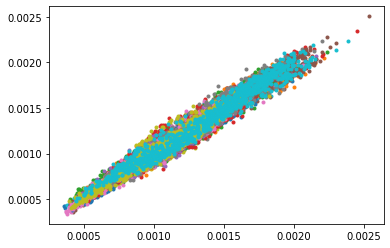

In [106]:
lin_cor_fc2 = []

for c in range(20):
    x = software[:,c]
    y = outputs[:,c]
    
    plt.plot(x,y,'.')

    lin_cor_fc2.append( np.polyfit(y, x, 1))

(array([1.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 9.000e+00, 7.000e+00,
        1.100e+01, 1.700e+01, 3.100e+01, 4.800e+01, 8.200e+01, 1.560e+02,
        1.850e+02, 2.730e+02, 3.590e+02, 4.590e+02, 5.850e+02, 7.030e+02,
        8.350e+02, 9.650e+02, 1.160e+03, 1.151e+03, 1.249e+03, 1.320e+03,
        1.369e+03, 1.313e+03, 1.332e+03, 1.216e+03, 1.043e+03, 9.620e+02,
        7.510e+02, 5.670e+02, 4.680e+02, 3.750e+02, 2.520e+02, 2.000e+02,
        1.590e+02, 1.050e+02, 7.900e+01, 5.100e+01, 3.700e+01, 3.000e+01,
        2.800e+01, 2.100e+01, 1.100e+01, 7.000e+00, 8.000e+00, 1.000e+00,
        3.000e+00, 3.000e+00]),
 array([-0.1076761 , -0.10325906, -0.09884201, -0.09442496, -0.09000791,
        -0.08559087, -0.08117382, -0.07675677, -0.07233973, -0.06792268,
        -0.06350563, -0.05908858, -0.05467154, -0.05025449, -0.04583744,
        -0.04142039, -0.03700335, -0.0325863 , -0.02816925, -0.02375221,
        -0.01933516, -0.01491811, -0.01050106, -0.00608402, -0.00166697,
         0.

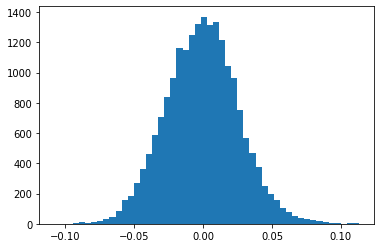

In [113]:
plt.hist((outputs-software).reshape(-1, 1)/0.0025, bins=50 )

In [112]:
(outputs-software).reshape(-1, 1).std()

6.573628287744503e-05

In [18]:
lin_cor_fc1 = [
       [ 1.65705364e+01, -4.76661730e-06],
       [ 1.52014391e+01, -7.32910667e-06],
       [ 1.83622860e+01, -1.03660227e-04],
       [ 1.46453131e+01,  8.72582481e-05],
       [ 1.57026572e+01,  5.49433331e-06],
       [ 1.75302910e+01, -5.91984363e-05],
       [ 1.70097444e+01, -3.77425017e-06],
       [ 1.66811834e+01, -5.92705383e-05],
       [ 1.58138030e+01, -8.54206565e-05],
       [ 1.47224922e+01, -1.01580546e-04],
       [ 1.63933874e+01,  2.75899701e-05],
       [ 1.73734414e+01, -6.44827939e-05],
       [ 1.72284591e+01, -1.78498676e-05],
       [ 1.56514926e+01,  4.85230992e-05],
       [ 1.82551529e+01, -6.58699418e-05],
       [ 1.80427640e+01,  3.35214924e-05],
       [ 1.68846215e+01,  5.83922590e-05],
       [ 1.78382218e+01, -5.84954866e-05],
       [ 1.59426072e+01, -2.58419590e-05],
       [ 1.77145924e+01, -3.09111781e-04]]

lin_cor_fc2 = [
       [ 1.49074642e+01,  3.04496037e-05],
       [ 1.66134607e+01, -6.65273335e-05],
       [ 1.71330302e+01, -1.16174943e-04],
       [ 1.70197025e+01, -5.26536591e-05],
       [ 1.57107974e+01, -7.15197241e-05],
       [ 1.70294047e+01, -7.92741963e-05],
       [ 1.73580128e+01, -7.60909714e-05],
       [ 1.84105096e+01, -2.43281137e-05],
       [ 1.68061704e+01, -2.11947699e-05],
       [ 1.51725578e+01, -2.68254150e-05],
       [ 1.85076350e+01, -3.41438100e-05],
       [ 1.60115486e+01, -3.91897704e-05],
       [ 1.56633900e+01,  5.07271500e-05],
       [ 1.78045219e+01, -8.48122737e-05],
       [ 1.53011229e+01,  6.33155863e-05],
       [ 1.49990127e+01,  8.11595510e-05],
       [ 1.75060714e+01,  4.32311953e-05],
       [ 1.79812969e+01, -1.50383469e-04],
       [ 1.58391025e+01,  3.87391613e-06],
       [ 1.58795906e+01, -1.12594198e-04]]

def lin_corr(outputs, factors):
    result = np.zeros(outputs.shape)
    for c in range(outputs.shape[1]):
        result[:,c] = outputs[:,c] * factors[c][0] + factors[c][1]
        
    return result

In [16]:
load_workspace(vars(), '20190820-055900-mnist_xs')
xs = np.array(xs)

Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, linear_factors_conv, c, x, i, result, x1, y, xs, acc, 


In [37]:
ys = []
batch_size = 1000

for i in range( (len(test_images)-1)//batch_size + 1 ):
    display.clear_output(wait=True)
    
    idx1 = i * batch_size
    idx2 = (i+1) * batch_size
    idx2 = idx2 if idx2<= len(test_images) else len(test_images)
    
    print(f'Running on sample {idx1}-{idx2}')

    x = xs[i*1000:(i+1)*1000]

    x1 = x[:,:57].T
    x2 = x[:,57:].T

    sc1 = x1.max()
    sc2 = x2.max()

    Gfc1 = nn.Gfc[:57]
    Gfc2 = nn.Gfc[57:]

    x1 = x1 / sc1
    x2 = x2 / sc2
    
    output1  = dpe.multiply(2, x1, c_sel=[0, 20])
    output1 = lin_corr(output1, lin_cor_fc1) * sc1

    output2  = dpe.multiply(2, x2, c_sel=[20, 40])
    output2 = lin_corr(output2, lin_cor_fc2) * sc2

    outputs = output1 + output2
    
    y = outputs[:,::2] - outputs[:,1::2]
    ys.append(y)
    
ys = np.concatenate(ys)  

Running on sample 9000-10000
Connecting to serial
[INFO] Elapsed time = 4.21s
Serial disconnected
Connecting to serial
[INFO] Elapsed time = 4.06s
Serial disconnected


In [38]:
np.mean(ys.argmax(axis=1) == test_labels)

0.7721

In [29]:
ynew.argmax(axis=1) == test_labels

array([ True,  True, False, ...,  True,  True,  True])